#### Table of Contents
- [Prediction with Logistic Regression](#prediction-with-logistic-regression)
  - [1. Variable: Kills](#variable-kills)
    - [i. Data Preparation](#data-preparation)
    - [ii. Logistic Regression Model](#logistic-regression-model)
    - [iii. Data Visualisation](#data-visualisation)
  - [2. Variable: Towers](#variable-towers)
    - [i. Data Preparation](#data-preparation)
    - [ii. Logistic Regression Model](#logistic-regression-model)
    - [iii. Data Visualisation](#data-visualisation)
  - [3. Variable: Multi-Variate](#variable-multivariate)
    - [i. Data Preparation](#data-preparation)
    - [ii. Data Preprocessing](#data-preprocessing)
    - [iii. Model Fitting](#model-fitting)
    - [iv. Data Visualisation](#data-visualisation)
  - [4. Variable: Multi-Variate before 30 Minutes](#variable-multivariate-30-minutes)
    - [i. Data Preparation](#data-preparation)
    - [ii. Data Preprocessing](#data-preprocessing)
    - [iii. Model Fitting](#model-fitting)
    - [iv. Data Visualisation](#data-visualisation)
  
*Author: Oscar*

# Prediction with Logistic Regression

Now having analysed the kill statistics to some extent, perhaps we can use logistics regression to predict the outcome of a match. This is possible since our dependant variable is binary (win/lose) and we will be using 'x kills obtained before y minutes' as our independant variable

Import libraries

In [86]:
#import basic libraries
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning, DeprecationWarning))
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from ast import literal_eval
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
import math

---
## Variable: Kills

### Data Preparation
Here we will prepare and clean the dataset like in EDA. What is done here should be the same in EDA

In [45]:
# helper function to extract time of kill
def extract_time(x):
    try:
        return [x[0] for x in x]
    except:
        return [0 for x in x]

In [46]:
# Import Dataset
league_data = pd.read_csv("datasets/LeagueofLegends.csv")
kill_data = pd.read_csv('datasets/kills.csv')

# Make a copy of df to work with
clean_df = league_data.copy(deep=True)

# Make a new column to show winners
clean_df['winner'] = np.where(clean_df['bResult'] == 1, 1, 2)

# Convert columns with lists object to real lists
cols = ['bKills', 'rKills', 'goldblue', 'goldred', 'bTowers', 'rTowers', 'bInhibs', 'rInhibs', 'bDragons', 'rDragons', 'bBarons', 'rBarons', 'bHeralds', 'rHeralds', 'golddiff']

for col in cols:
    clean_df[col] = clean_df[col].apply(literal_eval)

# make new column for time of kills of each match
clean_df['bKills_time'] = clean_df['bKills'].apply(extract_time)
clean_df['rKills_time'] = clean_df['rKills'].apply(extract_time)

# each row now is the kill time of a specific map, for either blue or red team
kills_df = clean_df[['bKills_time', 'rKills_time']].unstack().apply(pd.Series)

# map address and winner to the df
_Address = dict(zip(clean_df.index, clean_df['Address']))
_winner = dict(zip(clean_df['Address'], clean_df['winner']))
kills_df['Address'] = kills_df.index.get_level_values(1)
kills_df['Address'] = kills_df['Address'].map(_Address)
kills_df['winner'] = kills_df.index.get_level_values(1)
kills_df['winner'] = kills_df['Address'].map(_winner)

# make index into column
kills_df = kills_df.reset_index(level=0, drop=False)
kills_df = kills_df.rename(columns={'level_0':'type'})

# melt df 
kills_melt = pd.melt(kills_df, id_vars=['Address', 'type', 'winner'], var_name='counts').fillna(0)

# boolean 'won' column if the match is won by the team
kills_melt['won'] = False
kills_melt.loc[((kills_melt['type']=='bKills_time') & (kills_melt['winner'] == 1)) | ((kills_melt['type']=='rKills_time') & (kills_melt['winner'] == 2)), 'won'] = True
kills_melt['counts']+=1

# categories time into bins
kills_melt['bin'] = pd.cut(kills_melt['value'], bins=np.arange(0,96,5))

# remove null value and seperate into win/lose
kills_all = kills_melt[kills_melt['bin'].notnull()]
kills_all = kills_all[kills_all['value'] >=1]

---
### Logistic Regression Model

Here we will split the dataset into train/test (7:3) and perform logistic regression with sklearn's LogisticRegression model

In [47]:
# before y minutes
Y_MINUTE = 5

kills_reg = kills_all.copy(deep=True)
kills_reg = kills_reg[kills_reg['value'] <= Y_MINUTE]

# X = pd.DataFrame(kills_reg['counts'])
# y = pd.DataFrame(kills_reg['won'])
X = kills_reg['counts'].values.reshape(-1,1)
y = kills_reg['won'].values.reshape(-1,1)
# y = kills_reg['won']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

prediction = logreg.predict(X_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       580
        True       0.63      1.00      0.78       999

    accuracy                           0.63      1579
   macro avg       0.32      0.50      0.39      1579
weighted avg       0.40      0.63      0.49      1579



Looks like we are able to get a classification accuracy of ~63%

---
### Data Visualisation

Lets try to visualise this with matplotlib first

Intercept of regression line:  [-0.14048618]
Coefficient of regression line:  [[0.48198159]]


Text(0, 0.5, 'Winning Probability')

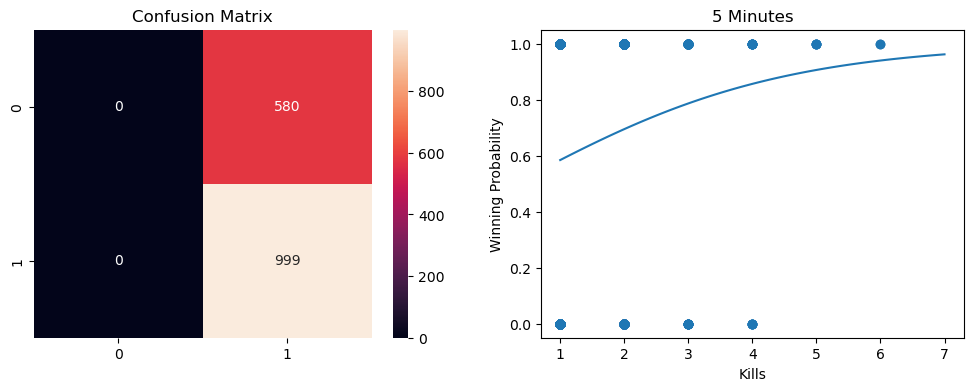

In [49]:
print('Intercept of regression line: ', logreg.intercept_)
print('Coefficient of regression line: ', logreg.coef_)
cm = confusion_matrix(y_test, logreg.predict(X_test))

# figure frame
f, ax = plt.subplots(1,2,figsize=(12,4))

# confusion matrix
p1 = plt.subplot2grid((1,2), (0,0))
sns.heatmap(data=cm, annot=True, fmt='.0f')
plt.title("Confusion Matrix")

# regression plot with matplotlib
p2 = plt.subplot2grid((1,2), (0,1))
plt.scatter(X_test,y_test)

#generate values for curve overlay
m = logreg.coef_[0,0]
b = logreg.intercept_[0]
lgs_curve = lambda x: 1/(1 + math.e**(-(m*x+b)))         
x_values = np.linspace(1, 7, 100)
y_values = lgs_curve(x_values)
plt.plot(x_values, y_values)
plt.title('5 Minutes')
plt.xlabel('Kills')
plt.ylabel('Winning Probability')

Now lets try using seaborn's lmplot which will be much easier

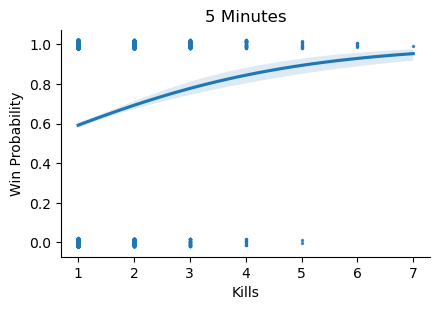

In [7]:
# lmplot with seaborn
sns.lmplot(data=kills_reg, x='counts', y='won', y_jitter=0.02, logistic=True, scatter_kws={'s': 2}, height=3, aspect=1.5)
plt.title('5 Minutes')
plt.ylabel('Win Probability')
plt.xlabel('Kills')
plt.show()

**Intepretation:**   
We can see that if a team gets 1 kill within the first 5 minute of the game, the chance of winning is around 60%. This chance of winning increases to >90% if the team manage to get >6 kills in the first 5 minutes of the game. This is logical since if a team is able to get >5 kills in the first 5 minutes, it is most likely that the entire team is winning the laning phase, and this means that if they can capitalise on the early advantage, then they are most likely to win the game    

Now, let's try to visualise this for other Y_MINUTE

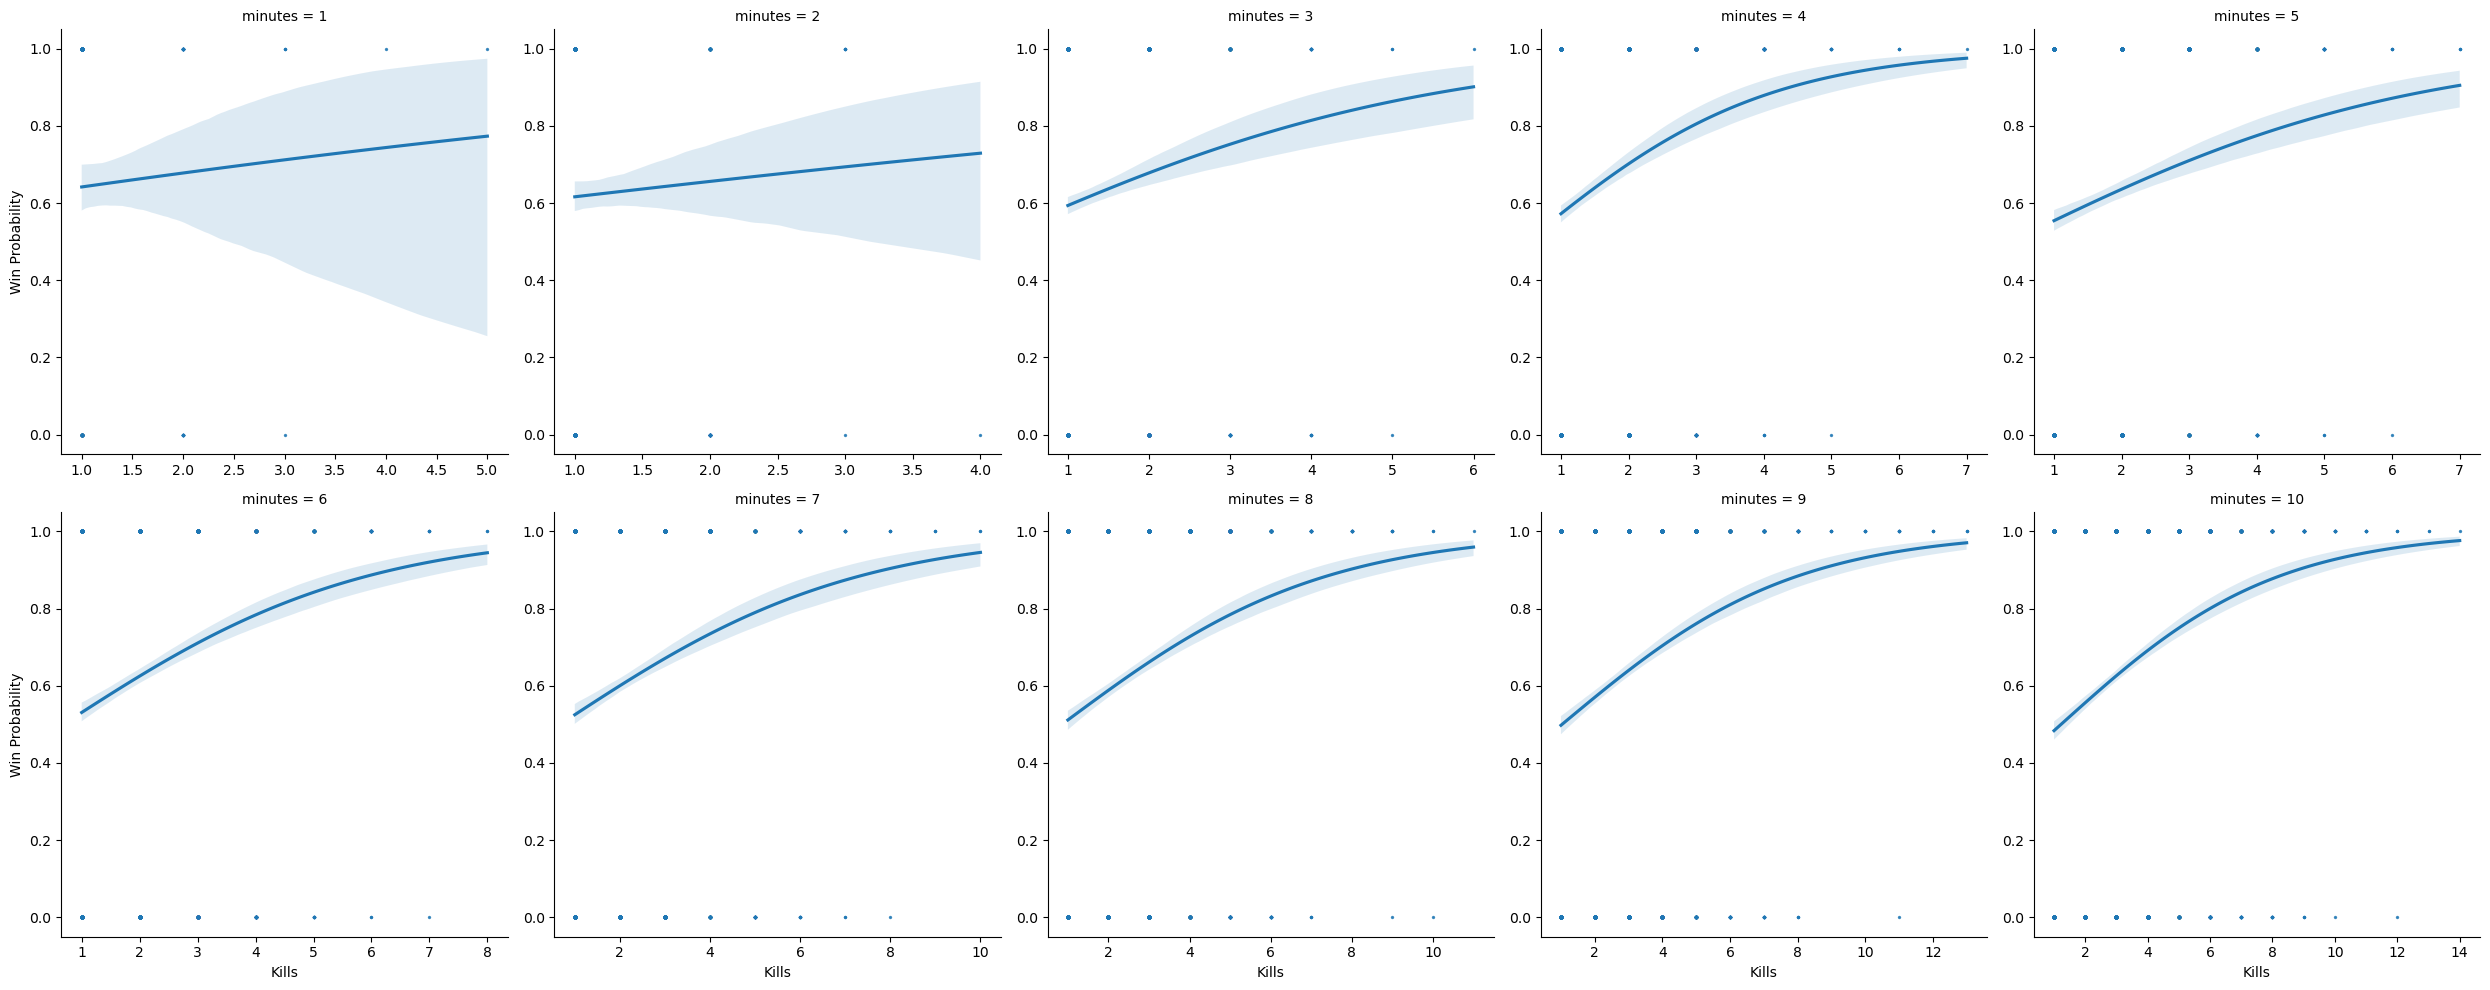

In [10]:
# before y minutes
Y_MINUTE = 10

kills_reg = kills_all.copy(deep=True)
kills_reg['minutes'] = kills_reg['value'].astype(int)
kills_reg = kills_reg[kills_reg['minutes'] <= Y_MINUTE]

p = sns.lmplot(data=kills_reg, x='counts', y='won',col='minutes', col_wrap=5, logistic=True, sharex=False, sharey=False, aspect=1, scatter_kws={'s':2})
p.set_xlabels('Kills')
p.set_ylabels('Win Probability')

**Comments:**   
A interesting observation is for graph of 'minute=1' and 'minute=2', every increase in number of kills in the first y minute of the game of leads to a very small increase in probability of winning the game. This could actually suggest that for META strategies such as early invasion of enemy's jungle, it might be a wiser decision to stop fighting after obtaining the first kill in game since the first kill can increase the probability of winning by around ~12% from 50%, while subsequent kills within the first 2 minutes in game only leads to marginal increase in the team's chance of winning.   

**Conclusion:**  
Possible strategy: It is important to get first kill in the first 2 minutes, but can stop fighting after the first kill is secured since the returns of subsequent kills is marginal. This is especially so for META strategies such as early invasion of enemy's jungle.Other than that, it is generally good to get kills early in the game as it can significantly boost your team's chance of winning.   

---

## Variable: Towers

We can try doing the same thing on any other variables. For now, lets try it on `towers takedown` to see if it can achieve a better classification accuracy. 

### Data Preparation

Here we will prepare the data in the same way as above, but for towers


In [62]:
# Import Dataset
structure_data = pd.read_csv('datasets/structures.csv')

# make new column for time of kills of each match
clean_df['bTowers_time'] = clean_df['bTowers'].apply(extract_time)
clean_df['rTowers_time'] = clean_df['rTowers'].apply(extract_time)

towers_df = clean_df[['bTowers_time', 'rTowers_time']].unstack().apply(pd.Series)

# map address and winner to the df
_Address = dict(zip(clean_df.index, clean_df['Address']))
_winner = dict(zip(clean_df['Address'], clean_df['winner']))
towers_df['Address'] = towers_df.index.get_level_values(1)
towers_df['Address'] = towers_df['Address'].map(_Address)
towers_df['winner'] = towers_df.index.get_level_values(1)
towers_df['winner'] = towers_df['Address'].map(_winner)

# make index into column
towers_df = towers_df.reset_index(level=0, drop=False)
towers_df = towers_df.rename(columns={'level_0':'type'})

# melt df 
towers_melt = pd.melt(towers_df, id_vars=['Address', 'type', 'winner'], var_name='counts').fillna(0)

# boolean 'won' column if the match is won by the team
towers_melt['won'] = False
towers_melt.loc[((towers_melt['type']=='bTowers_time') & (towers_melt['winner'] == 1)) | ((towers_melt['type']=='rTowers_time') & (towers_melt['winner'] == 2)), 'won'] = True
towers_melt['counts']+=1

# categories time into bins
towers_melt['bin'] = pd.cut(towers_melt['value'], bins=np.arange(0,96,5))

# remove null value and seperate into win/lose nad remove less than 5 min since that is a bit weird
towers_all = towers_melt[towers_melt['bin'].notnull()]
towers_all = towers_all[towers_all['value'] >=5]

In [63]:
towers_all

,Address,type,winner,counts,value,won,bin
0,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,1,1,27.542,True,"(25, 30]"
1,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,2,1,23.239,False,"(20, 25]"
2,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,1,1,15.045,True,"(15, 20]"
3,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,2,1,19.941,False,"(15, 20]"
4,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,1,1,22.594,True,"(20, 25]"
...,...,...,...,...,...,...,...
198158,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,1,14,12.389,True,"(10, 15]"
207818,http://matchhistory.na.leagueoflegends.com/en/...,rTowers_time,2,14,32.001,True,"(30, 35]"
213362,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,1,15,29.505,True,"(25, 30]"
213398,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,1,15,38.314,True,"(35, 40]"


---
### Logistic Regression Model

Here we will split the dataset into train/test (7:3) and perform logistic regression with sklearn's LogisticRegression model

In [65]:
# before y minutes
Y_MINUTE = 15
towers_reg = towers_all.copy(deep=True)
towers_reg = towers_reg[towers_reg['value'] <= Y_MINUTE]

X = towers_reg['counts'].values.reshape(-1,1)
y = towers_reg['won'].values.reshape(-1,1)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

prediction = logreg.predict(X_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

       False       0.60      0.60      0.60      1442
        True       0.77      0.77      0.77      2531

    accuracy                           0.71      3973
   macro avg       0.69      0.69      0.69      3973
weighted avg       0.71      0.71      0.71      3973



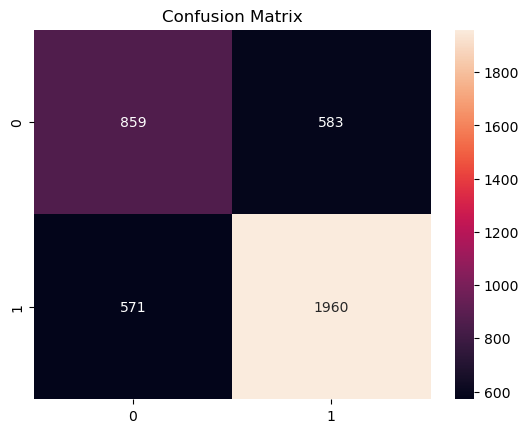

In [66]:
cm = confusion_matrix(y_test, logreg.predict(X_test))
sns.heatmap(data=cm, annot=True, fmt='.0f')
plt.title("Confusion Matrix")
plt.show()

Looks like towers seems to be a better variable to predict for out come of a game since we are about to get a classification accuracy of ~71% here

---

### Data Visualisation

We will visualise the logistic regression here too

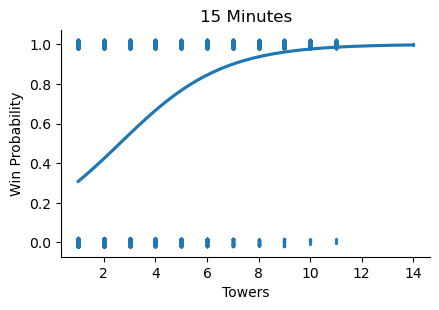

In [67]:
# lmplot with seaborn
sns.lmplot(data=towers_reg, x='counts', y='won', y_jitter=0.02, logistic=True, scatter_kws={'s': 2}, height=3, aspect=1.5)
plt.title('15 Minutes')
plt.ylabel('Win Probability')
plt.xlabel('Towers')
plt.show()

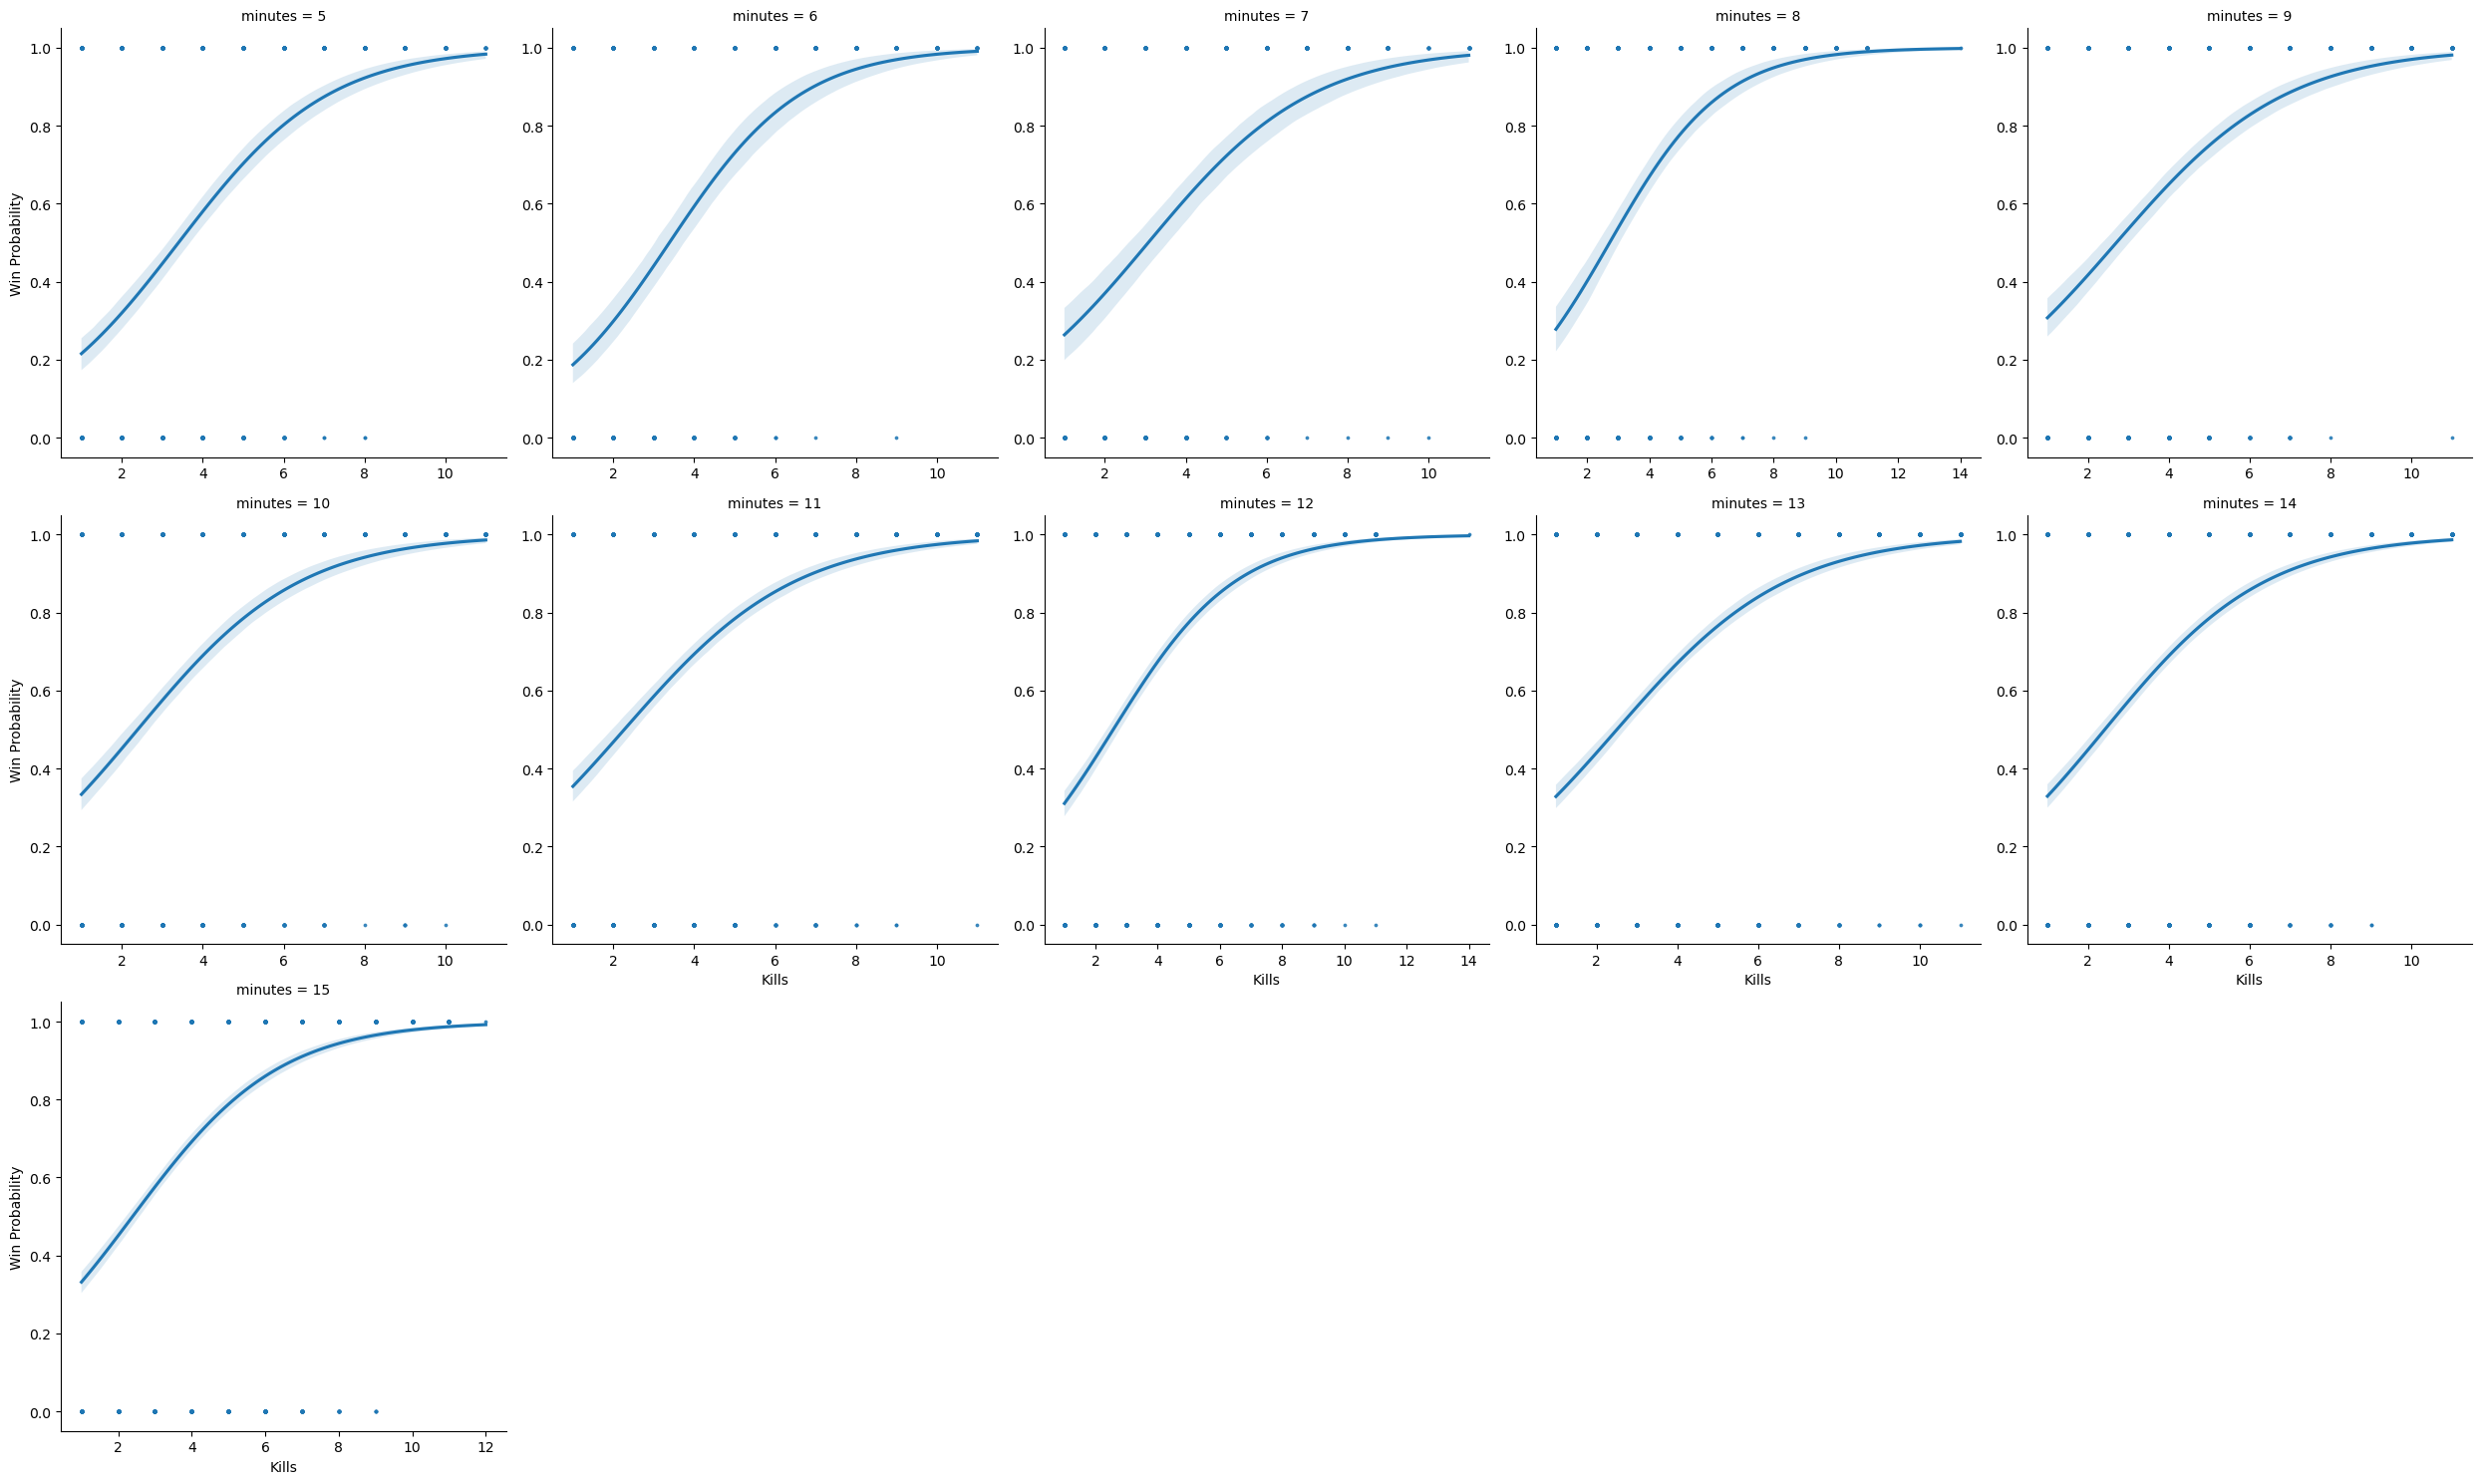

In [68]:
# before y minutes
Y_MINUTE = 15

towers_reg = towers_all.copy(deep=True)
towers_reg['minutes'] = towers_reg['value'].astype(int)
towers_reg = towers_reg[towers_reg['minutes'] <= Y_MINUTE]

p = sns.lmplot(data=towers_reg, x='counts', y='won',col='minutes', col_wrap=5, logistic=True, sharex=False, sharey=False, aspect=1, scatter_kws={'s':3})
p.set_xlabels('Kills')
p.set_ylabels('Win Probability')

**Comments:**   
Now looking at the 5 minutes graph, a interesting thing here is that in contrast to Kills is that taking down 1 turret before 5 minutes actually results in a lower probability of winning. The probability of winning only becomes >50% after getting 3 tower takedowns. This is indeed a extremely weird sight. 

Using Logistic Regression, we are only able to get a accuracy of ~64% for kills variable and slightly better, ~77% for towers variable. Moreover, it only takes into account of 1 attribute in the game at a time. Hence, we should seek for better models to predict outcome of the game   

**Possible strategy:**   
We can see that getting 1-2 kills before 3 minutes translates to a significant increased chance of winning however, anything more only yields marginal increase in chances of winning, this sheds some light into common strategies such as early jungle invasion. Early jungle Invasion is a viable strategy to potentailly get some very early kills within the first 1-2 minutes of the game. However, after obtaining the first kill, subsequent kills yields *marginal* advantage for the team. Hence, it might be wiser to not greed for more kills after getting the first 2 kills, but instead focus on laning phase, where the effects of a kill is much more significant.

---

## Variable: Multivariate

We can continue to perform logistic regression on each of the variables but there is no point in doing so. I'll just use all the variables to fit the logistic model now.   

### Data Preparation

We first try using data of the entire game of each match. We should expect a high accuracy for this model since we are using the entire game's data. Each column will be the count of each event at the end of the game.   

In [6]:
# make a new df with only columns we are onterested in
# sums up all the variables
new_df = pd.DataFrame()

new_df['goldbluetotal'] = clean_df['goldblue'].apply(max)
new_df['bKills'] = clean_df['bKills'].apply(len)
new_df['bTowers'] = clean_df['bTowers'].apply(len)
new_df['bDragons'] = clean_df['bDragons'].apply(len)
new_df['bInhibs'] = clean_df['bInhibs'].apply(len)
new_df['bBarons'] = clean_df['bBarons'].apply(len)
new_df['bHeralds'] = clean_df['bHeralds'].apply(len)

new_df['goldredtotal'] = clean_df['goldred'].apply(max)
new_df['rKills'] = clean_df['rKills'].apply(len)
new_df['rTowers'] = clean_df['rTowers'].apply(len)
new_df['rDragons'] = clean_df['rDragons'].apply(len)
new_df['rInhibs'] = clean_df['rInhibs'].apply(len)
new_df['rBarons'] = clean_df['rBarons'].apply(len)
new_df['rHeralds'] = clean_df['rHeralds'].apply(len)

new_df['winner'] = clean_df['winner']
new_df = new_df.reset_index(drop=True)

# make a df where each row is info of each team for a particular match
blue_matches = pd.DataFrame()

blue_matches['TotalGold'] = new_df['goldbluetotal']
blue_matches['TotalKills'] = new_df['bKills']
blue_matches['TotalTowers'] = new_df['bTowers']
blue_matches['TotalDragons'] = new_df['bDragons']
blue_matches['TotalInhibs'] = new_df['bInhibs']
blue_matches['TotalBarons'] = new_df['bBarons']
blue_matches['TotalHeralds'] = new_df['bHeralds']
blue_matches['won'] = False
blue_matches.loc[new_df['winner'] == 1, 'won'] = True

red_matches = pd.DataFrame()

red_matches['TotalGold'] = new_df['goldredtotal']
red_matches['TotalKills'] = new_df['rKills']
red_matches['TotalTowers'] = new_df['rTowers']
red_matches['TotalDragons'] = new_df['rDragons']
red_matches['TotalInhibs'] = new_df['rInhibs']
red_matches['TotalBarons'] = new_df['rBarons']
red_matches['TotalHeralds'] = new_df['rHeralds']
red_matches['won'] = False
red_matches.loc[new_df['winner'] == 2, 'won'] = True

all_matches = pd.concat([blue_matches, red_matches])

all_matches

,TotalGold,TotalKills,TotalTowers,TotalDragons,TotalInhibs,TotalBarons,TotalHeralds,won
0,62729,16,9,1,2,0,0,True
1,57702,10,7,3,0,1,0,False
2,70270,22,15,4,4,1,0,True
3,58612,10,4,0,0,1,0,False
4,60269,22,8,2,1,1,0,True
...,...,...,...,...,...,...,...,...
7615,65618,16,9,3,1,2,0,True
7616,70498,18,10,2,2,0,1,True
7617,52338,13,11,2,3,1,1,True
7618,57221,2,3,0,0,0,0,False


<Axes: xlabel='TotalGold', ylabel='won'>

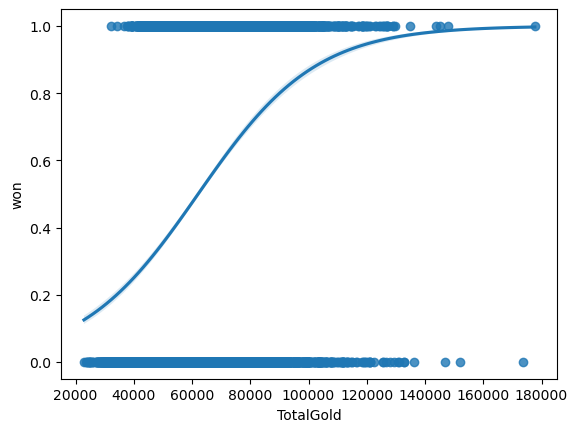

In [20]:
plt.subplots()
sns.regplot(data=all_matches, x='TotalGold', y='won', logistic=True)

### Data Preprocessing

Since we are doing multivariate logistic regresison here, we will have to scale the variables since the variables are not of the same scale. Especially *TotalGold* which is in the thousands while the rest are in the tens.

In [101]:
# Split dataframe to x and y data
x_data = all_matches.drop(['won'], axis=1)
y_data = all_matches['won']

# scale the variables
Scaler = preprocessing.MinMaxScaler()
Scaler.fit(x_data)
X_data_scaled = Scaler.transform(x_data)

data = pd.DataFrame(X_data_scaled, columns=['TotalGold', 'TotalKills', 'TotalTowers', 'TotalDragons', 'TotalInhibs', 'TotalBarons', 'TotalHeralds'])
data

,TotalGold,TotalKills,TotalTowers,TotalDragons,TotalInhibs,TotalBarons,TotalHeralds
0,0.257393,0.225352,0.5625,0.125,0.142857,0.000000,0.000000
1,0.224922,0.140845,0.4375,0.375,0.000000,0.166667,0.000000
2,0.306101,0.309859,0.9375,0.500,0.285714,0.166667,0.000000
3,0.230800,0.140845,0.2500,0.000,0.000000,0.166667,0.000000
4,0.241503,0.309859,0.5000,0.250,0.071429,0.166667,0.000000
...,...,...,...,...,...,...,...
15235,0.276053,0.225352,0.5625,0.375,0.071429,0.333333,0.000000
15236,0.307574,0.253521,0.6250,0.250,0.142857,0.000000,0.333333
15237,0.190275,0.183099,0.6875,0.250,0.214286,0.166667,0.333333
15238,0.221815,0.028169,0.1875,0.000,0.000000,0.000000,0.000000


Here we will use **Principal Component Analysis (PCA)** on order to reduce the dimensions, thus allowing us to visualise the data in a easier way.

In [102]:
# apply pca
pca = PCA(n_components=1)
pca.fit(X_data_scaled)
x_pca = pca.transform(X_data_scaled)
x_pca

array([[ 0.04548009],
       [ 0.05896757],
       [ 0.60259846],
       ...,
       [ 0.28441011],
       [-0.36866868],
       [ 0.42236863]])

### Model Fitting
Here we will do the train/test split into 7:3. Then we can finally fit the logistic regression model with our data.   

Classification report:
              precision    recall  f1-score   support

       False       0.95      0.90      0.93      2313
        True       0.90      0.95      0.93      2259

    accuracy                           0.93      4572
   macro avg       0.93      0.93      0.93      4572
weighted avg       0.93      0.93      0.93      4572

Accuracy:  0.9267279090113736


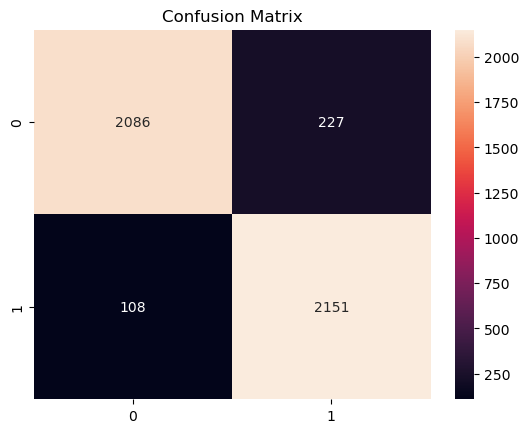

In [103]:
# train test split here
X_train, X_test, y_train, y_test = train_test_split(x_pca, y_data, test_size=0.3, random_state=1)

def LogReg(print_result=False):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if print_result == True:
        sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt='.0f')
        plt.title('Confusion Matrix')
        print('Classification report:')
        print(classification_report(y_test, y_pred))
    return accuracy, logreg.coef_, logreg.intercept_

print("Accuracy: ", LogReg(True)[0])

As expected, we were able to obtain a model with high accuray of **~92%**. 

### Data Visualisation

Similarly, we will try to first manually visualise the Logistic regression, we can do this easily as we have applied PCA to our multi variables. After that we will use the seaborn's lmplot to visualise it again. Just 2 different ways of doing the same thing.



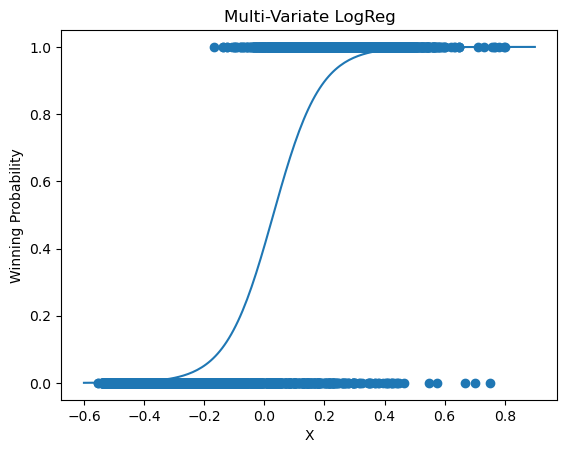

In [137]:
#generate values for curve overlay
plt.scatter(X_test,y_test)

_, m, b = LogReg(False)
lgs_curve = lambda x: 1/(1 + math.e**(-(m[0,0]*x+b[0])))         
x_values = np.linspace(-0.6, 0.9, 200)
y_values = lgs_curve(x_values)
plt.plot(x_values, y_values)
plt.title('Multi-Variate LogReg')
plt.xlabel('X')
plt.ylabel('Winning Probability')
plt.show()

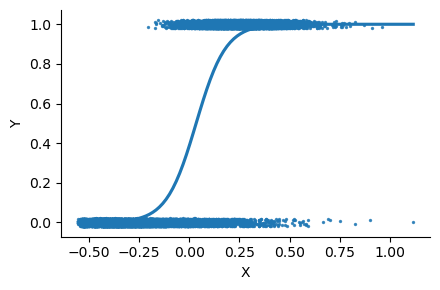

In [136]:
y_data = y_data.reset_index(drop=True)
y_data = pd.DataFrame(y_data)
dataplot = pd.DataFrame(x_pca, columns=['X'])
dataplot['Y'] = y_data
dataplot
sns.lmplot(data=dataplot, x='X', y='Y', y_jitter=0.02, logistic=True, scatter_kws={'s': 2}, height=3, aspect=1.5)

**Comments:**   
Although the accuracy for this model is high, however, there are little practical use of this model since it uses the data after the match have ended. Next we will try to only use data until 30 minutes of the game. 

---

## Variable: Multivariate 30 Minutes

Now, we will restrict the data that we fit the model with. We should expect in a drop in accuracy.

### Data Preparation

Now we will only take data of matches untill 30 minutes. We will expect some drop in accuracy, but this model will be of more practical use.

In [138]:
T_LENGTH = 30

# helper function to convert variables into an array showing how many of that event occurred every minute in the game
def to_array(x):
    array = np.zeros(T_LENGTH, dtype=np.int8) # an array of zeros of length=T_LENGTH, here we will use the smallest int8 since the number wont be big
    for time in range(T_LENGTH):
        for item in x:
            if item[0] <= time+1:
                array[time] += 1

    return array

def to_array_gold(x):
    array = []
    for time in range(T_LENGTH):
        try:
            array.append(x[time])
        except IndexError:
            array.append(array[-1])

    return array

def getLastValue(aList):
    return aList[-1]

In [139]:
# remove matches that is less than 30 minutes
clean_df = clean_df[clean_df['gamelength'] >= T_LENGTH]
clean_df = clean_df.reset_index(drop=True)
clean_df.shape

(6384, 60)

In [140]:
# combine red and blue variables by making a new columns representing their differences
blue_matches = pd.DataFrame()

blue_matches['TotalGold'] = clean_df['goldblue'].apply(to_array_gold).apply(getLastValue)
blue_matches['TotalKills'] = clean_df['bKills'].apply(to_array).apply(getLastValue)
blue_matches['TotalTowers'] = clean_df['bTowers'].apply(to_array).apply(getLastValue)
blue_matches['TotalDragons'] = clean_df['bDragons'].apply(to_array).apply(getLastValue)
blue_matches['TotalInhibs'] = clean_df['bInhibs'].apply(to_array).apply(getLastValue)
blue_matches['TotalBarons'] = clean_df['bBarons'].apply(to_array).apply(getLastValue)
blue_matches['TotalHeralds'] = clean_df['bHeralds'].apply(to_array).apply(getLastValue)
blue_matches['won'] = False
blue_matches.loc[clean_df['winner'] == 1, 'won'] = True

red_matches = pd.DataFrame()

red_matches['TotalGold'] = clean_df['goldred'].apply(to_array_gold).apply(getLastValue)
red_matches['TotalKills'] = clean_df['rKills'].apply(to_array).apply(getLastValue)
red_matches['TotalTowers'] = clean_df['rTowers'].apply(to_array).apply(getLastValue)
red_matches['TotalDragons'] = clean_df['rDragons'].apply(to_array).apply(getLastValue)
red_matches['TotalInhibs'] = clean_df['rInhibs'].apply(to_array).apply(getLastValue)
red_matches['TotalBarons'] = clean_df['rBarons'].apply(to_array).apply(getLastValue)
red_matches['TotalHeralds'] = clean_df['rHeralds'].apply(to_array).apply(getLastValue)
red_matches['won'] = False
red_matches.loc[clean_df['winner'] == 2, 'won'] = True

all_matches = pd.concat([blue_matches, red_matches])
all_matches

,TotalGold,TotalKills,TotalTowers,TotalDragons,TotalInhibs,TotalBarons,TotalHeralds,won
0,45845,9,6,0,1,0,0,True
1,43767,8,5,2,0,1,0,False
2,49255,15,6,2,0,0,0,True
3,41672,7,3,0,0,0,0,False
4,46935,14,4,1,0,0,0,True
...,...,...,...,...,...,...,...,...
6379,53774,7,3,3,0,1,0,True
6380,54297,12,5,3,0,1,0,True
6381,52150,12,6,1,0,0,1,True
6382,48746,2,2,0,0,0,0,False


### Data Preprocessing

We will do the same here and apply scale to the data.

In [141]:
# Split dataframe to x and y data
x_data = all_matches.drop(['won'], axis=1)
y_data = all_matches['won']

# scale the variables
Scaler = preprocessing.MinMaxScaler()
Scaler.fit(x_data)
X_data_scaled = Scaler.transform(x_data)

data = pd.DataFrame(X_data_scaled, columns=['TotalGold', 'TotalKills', 'TotalTowers', 'TotalDragons', 'TotalInhibs', 'TotalBarons', 'TotalHeralds'])
data

,TotalGold,TotalKills,TotalTowers,TotalDragons,TotalInhibs,TotalBarons,TotalHeralds
0,0.382971,0.163636,0.545455,0.0,0.166667,0.0,0.000000
1,0.318139,0.145455,0.454545,0.4,0.000000,0.5,0.000000
2,0.489361,0.272727,0.545455,0.4,0.000000,0.0,0.000000
3,0.252777,0.127273,0.272727,0.0,0.000000,0.0,0.000000
4,0.416979,0.254545,0.363636,0.2,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
12763,0.630351,0.127273,0.272727,0.6,0.000000,0.5,0.000000
12764,0.646668,0.218182,0.454545,0.6,0.000000,0.5,0.000000
12765,0.579683,0.218182,0.545455,0.2,0.000000,0.0,0.333333
12766,0.473481,0.036364,0.181818,0.0,0.000000,0.0,0.000000


Same as above, apply **PCA** to help us visualise the result easily.

In [142]:
# apply pca
pca = PCA(n_components=1)
pca.fit(X_data_scaled)
x_pca = pca.transform(X_data_scaled)
x_pca

array([[-0.14034719],
       [ 0.22334244],
       [ 0.04471637],
       ...,
       [ 0.02376406],
       [-0.3556991 ],
       [ 0.29010251]])

### Model Fitting
Here we will do the train/test split into 7:3. Then we can finally fit the logistic regression model with our data.   

Classification report:
              precision    recall  f1-score   support

       False       0.77      0.84      0.80      1952
        True       0.81      0.74      0.78      1879

    accuracy                           0.79      3831
   macro avg       0.79      0.79      0.79      3831
weighted avg       0.79      0.79      0.79      3831

Accuracy:  0.7901331245105716


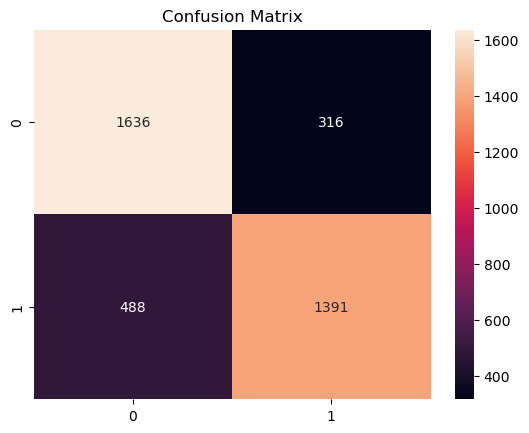

In [143]:
# train test split here
X_train, X_test, y_train, y_test = train_test_split(x_pca, y_data, test_size=0.3, random_state=1)

def LogReg(print_result=False):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if print_result == True:
        sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt='.0f')
        plt.title('Confusion Matrix')
        print('Classification report:')
        print(classification_report(y_test, y_pred))
    return accuracy, logreg.coef_, logreg.intercept_

print("Accuracy: ", LogReg(True)[0])

Yup, not surprising, we see a decrease in accuracy of our model to about **~79%**. But still pretty decent.

### Data Visualisation

Similarly, we will try to manually visualise the Logistic regression.

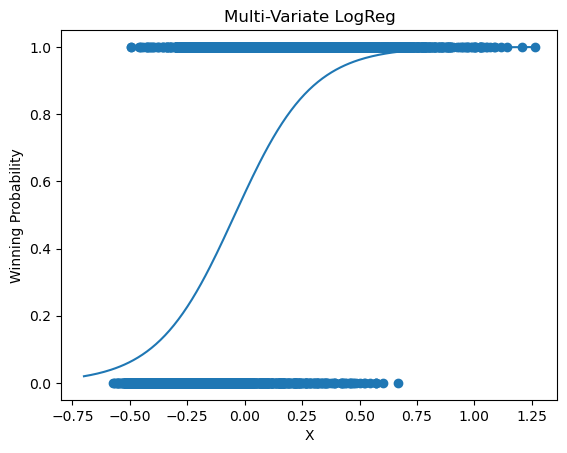

In [146]:
#generate values for curve overlay
plt.scatter(X_test,y_test)

_, m, b = LogReg(False)
lgs_curve = lambda x: 1/(1 + math.e**(-(m[0,0]*x+b[0])))         
x_values = np.linspace(-0.7, 1.25, 200)
y_values = lgs_curve(x_values)
plt.plot(x_values, y_values)
plt.title('Multi-Variate LogReg')
plt.xlabel('X')
plt.ylabel('Winning Probability')
plt.show()

**Comments:**   
Overall, I'm pretty satisfied with what we have built in this notebook. We started from using single variables to multi variated logistic regression. Despite the drop in accuracy, the final model here have the most practical usage, being able to predict the outcome of a match base on the data from first 30 minutes of a game.   

---
Continue in `Champions_Analysis.ipynb`